In [10]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import *
import os

In [11]:
main_dataset_dir = "brain_tumor_dataset/brain_tumor_classification/"
os.listdir(main_dataset_dir + "Training")


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [12]:
main_dataset_labels = np.array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [14]:
train_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="training"
)

# Normalize the images using tf.map()
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

validation_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Training",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,
    validation_split=0.2,
    subset="validation"
)

# Normalize the images using tf.map()
validation_dataset = validation_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

test_dataset = image_dataset_from_directory(
    directory=main_dataset_dir+"Testing",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=74,   
)

# Normalize the images using tf.map()
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32)/255.0,y))

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


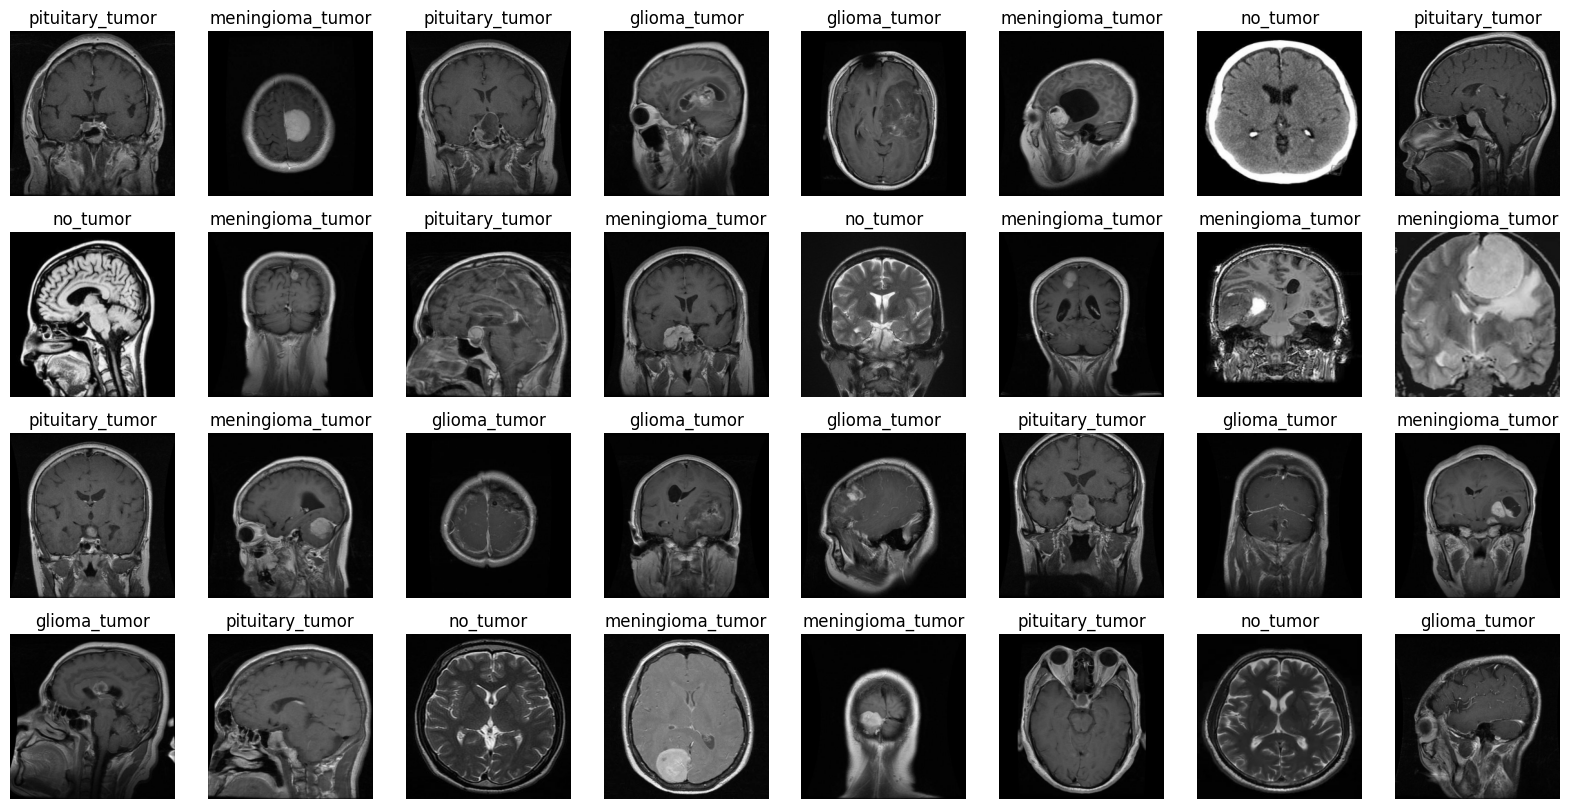

In [15]:
plt.figure(figsize=(20, 10))
i = 1
for image, label in train_dataset.take(1).unbatch():
    image = image.numpy()
    label = main_dataset_labels[np.argmax(label.numpy())]
    plt.subplot(4, 8, i)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    i += 1

In [16]:
def VGG16_based_model():
    base_model = VGG16(
        weights = "imagenet", 
        input_shape = (256, 256, 3),
        include_top = False, 
    )

    base_model.trainable = False

    input = Input((256, 256, 3))
    x = RandomRotation(factor=(-0.2, 0.2))(input)
    x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
    x = RandomContrast(factor= (0.8, 1.2))(x)
    x = base_model(input, training=False)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu")(x)
    output = Dense(4, activation="linear")(x)
    
    return Model(inputs=input, outputs=output),base_model

In [17]:
model_1, base_models_1 = VGG16_based_model()

In [18]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,405,316 (184.65 MB)

 Trainable params: 33,625,092 (128.27 MB)

 Non-trainable params: 14,780,224 (56.38 MB)

In [19]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=["accuracy"])

In [20]:
checkpoint_file_path_1 = "./Checkpoints/model_1.keras"
callbacks_1 = [
    EarlyStopping(
        monitor = "val_loss", 
        min_delta = 1e-3, 
        patience = 3,
        start_from_epoch = 10,
        restore_best_weights = True, 
    ),
    ModelCheckpoint(
        filepath = checkpoint_file_path_1,
        monitor = "val_loss",
        save_best_only = True,
    )
]

In [ ]:
hist_1 = model_1.fit(train_dataset, epochs=5, callbacks=callbacks_1, validation_data=validation_dataset)


Epoch 1/5


In [ ]:
model_1.evaluate(test_dataset)

In [ ]:
for layer in base_models_1.layers:
    layer.trainable = True

In [ ]:
model_1.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(1e-5), metrics=["accuracy"])

In [ ]:
hist_1_2 = model_1.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks = callbacks_1)

In [ ]:
model_1.evaluate(test_dataset)

In [ ]:
model_1.save("MRI_VGG_16_Tuned.keras")
base_models_1.save("MRI_VGG_16_Tuned_Base.keras")

In [ ]:
model_1.save_weights("MRI_VGG_16_Tuned.weights.h5")
base_models_1.save_weights("MRI_VGG_16_Tuned_Base.weights.h5")

In [ ]:
hist = hist_1_2.history
plt.plot(hist["loss"], label="Loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.title("Loss per epochs")
plt.legend()
plt.show()

In [ ]:
base_models_1.summary()

In [ ]:
counts = tf.Variable([0, 0, 0, 0], dtype=tf.float32)
for _, label in train_dataset.unbatch().take(-1):
    counts.assign_add(label)

In [ ]:
counts

In [ ]:
def visualize_result(dataset):
    plt.figure(figsize=(20, 12))
    i = 1
    for image, label in dataset.take(1).unbatch().take(32):
        image = image.numpy()
        label = main_dataset_labels[np.argmax(label.numpy())]
        predicted_label = main_dataset_labels[np.argmax(model_1.predict(np.reshape(image, (1,) + image.shape), verbose=False))]
        plt.subplot(4, 8, i)
        plt.imshow(image)
        plt.title(f"Label: {label}\nPredicted: {predicted_label}")
        plt.axis("off")
        i += 1

In [ ]:
visualize_result(test_dataset)